<hr style = "height:2px">

# **RNN** 

rnn 이란 매번 입력값을 독립적으로 처리하는 일반 신경망과 달리 데이터의 시간적인 순서를 고려하여 학습하기 위해 개발되었다.


## RNN 전파과정


이것은 '이전의 결과가 그 후의 학습에 영향을 미친다' 라는 발상으로부터 시간적으로 보면 다음과 같은 연산과정을 거친다. 

![대체 텍스트](https://drive.google.com/uc?id=1fe-oK42UPdEW5AJ1Rqt1kXTFsZXCw2v3)

실제로는 어떤 레이어의 출력이 다시 다음 입력과 함께 입력되므로 인해 일종의 재귀 순환 구조를 거침으로서 Recurrent Neural Network 라고 표현한다.  이를 간단한 슈도코드로 작성해 보면 다음과 같은 연산과정을 거친다. 



In [9]:
import numpy as np
output_features, input_features = 2,4 
inputs, outputs = [[0,1,1,1],[1,1,0,0]], []
state_t = [0,0]

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
print(W, "\n\n", U, "\n\n", b )

[[0.35185863 0.83626421 0.44259982 0.38113122]
 [0.80377753 0.81763545 0.86327594 0.06880811]] 

 [[0.43777808 0.93140559]
 [0.95458857 0.66124088]] 

 [0.10615505 0.58537292]


In [10]:

for input_t in inputs : 
  iw = np.dot(W, input_t)
  us = np.dot(U, state_t)
  
  out_t = np.tanh( iw + us + b)
  print("iw:\n",iw,"\nus:\n",us, "\nout_t:\n", out_t, "\n")

  outputs.append(out_t)
  state_t = out_t


iw:
 [1.65999525 1.7497195 ] 
us:
 [0. 0.] 
out_t:
 [0.94318596 0.98143291] 

iw:
 [1.18812284 1.62141297] 
us:
 [1.32701823 1.54931809] 
out_t:
 [0.98948253 0.99890785] 



In [0]:
final = np.stack(outputs, axis=0)
print(final)

[[0.73010601 0.74151561]
 [0.93388332 0.9678555 ]
 [0.97612968 0.99548766]]


## RNN 피드백

### BPTT

RNN의 피드백 과정은 그 원리는 일반 신경망과 유사하지만 모든 과정상에서 책임을 묻기 위해서 시간을 거슬러 지속적으로 이뤄진다. 이는 첫 입력 데이터는 한번의 피드백이 발생하지만 2번째 데이터는 2번, 3번째 데이터에 대해서는 3번.. 이런식으로 지속적으로 피드백 과정이 증가한다.  이를 Backpropagation Through Time (BPTT) 라고 명명한다. 

![대체 텍스트](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile23.uf.tistory.com%2Fimage%2F99DB59465BD2ACC420D345)




### Truncated BPTT

BPTT 는 연속적인 입력값이 매우 거대할 경우 그 피드백과정이 기하급수적으로 증가하기 때문에 한계를 갖고 있었다. 그래서 절충으로 과거의 n 단계까지만 피드백을 수행하는 방법이 나왔는데 이를 Truncated BPTT 라고 칭하며 실제로는 이 경우를 더 자주 사용한다.  다음의 그림은 2단계까지만 피드백을 지속하는 Truncated BPTT 의 예이다. 

![대체 텍스트](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile9.uf.tistory.com%2Fimage%2F99C0F9475BD2ACDB23A93B)

## RNN in Keras

RNN 이라고 해도 그 출력이 다음 학습에 입력으로 영향을 미친다는 것을 제외하면 일반적인 Dense 레이어와 크게 다르지 안다. 그러므로 케라스에서 이를 사용하는 것도 Dense layer 와 유사하게 사용된다. 

In [17]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(2, input_shape = (1,1)))
model.add(Dense(1, activation = "linear"))
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 2)                 8         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


## RNN 으로 시계열 예측 예제

이제 가장 기초적인 RNN 하나를 작성해보도록 하자.  시계열 데이터를 위해서 회귀 분석에서 사용하던 간단한 그래프 하나를 사용하도록 하겠다.

RNN의 입력은 기본적으로 2차원 구조로 지원된다. 그러므로 아무리 간단한 1차원 입력이라도 (1,1) 형태가 되어야 하며 이들의 연속입력은 (n,1,1) 구조가 되어야 한다. 

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 

n = 100
x = np.linspace(0, np.pi * 4 ,  n) 
y = np.sin(x) * 3 + x + np.random.normal(0,0.2,n)

plt.plot(x,y,'.')

x = y[ :99, np.newaxis, np.newaxis]
y = y[1:]
print(x.shape, y.shape)
print( x[0][0][:5], y[:5])

(99, 1, 1) (99,)
[0.13628121] [0.71925682 0.99496469 1.59120261 2.06692125 2.59833753]


모델은 가장 원시적인 형태의 노드 1개짜리 RNN 으로 구성해 보았다. 이를 900회 반복시행하면 다음과 같은 결과가 나온다. 

In [4]:
import keras
from keras.models import Sequential
from keras.layers import  SimpleRNN, Dense
keras.backend.clear_session()
model = Sequential()
model.add(SimpleRNN(3, input_shape = (1,1)))
model.add(Dense(1, activation="linear"))
model.compile(loss='mse', optimizer='sgd')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3)                 15        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x, y, steps_per_epoch = 30, epochs = 30).history

Epoch 1/30
30/30 [==============================] - 0s 3ms/step - loss: 0.5272
Epoch 2/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5392
Epoch 3/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5220
Epoch 4/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5341
Epoch 5/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5171
Epoch 6/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5293
Epoch 7/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5126
Epoch 8/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5248
Epoch 9/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5084
Epoch 10/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5204
Epoch 11/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5044
Epoch 12/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5163
Epoch 13/30
30/30 [==============================

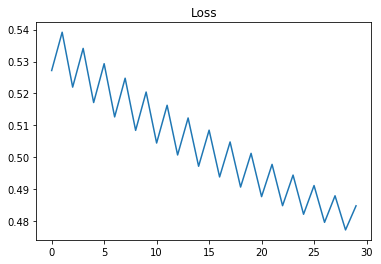

In [8]:
plt.plot(history["loss"])
plt.title("Loss")
plt.show()

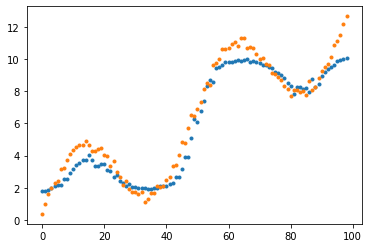

In [24]:
plt.plot(model.predict(x),'.')
plt.plot(y,'.')
plt.show()

### <font color = 'red'> 연습문제 7-1 : RNN 조작해보기

위의 예제는 학습시 로스의 수렴값이나 출력 그래프를 보면 입력데이터의 예측오차가 좀 발생하고 있음을 알 수 있다. 위의 네트워크를 조작해서 정확도를 높이는 방법이 있는지 찾아보자

<hr style="height:2px" >

# LSTM 

RNN의 문제는 바로 직전의 출력값에 대한 의존이 너무 크다라는 점이다.  데이터의 경우에 따라서는 n세대 이전의 입력이 결정적인 역할을 할 수 있음에도 불구하고 n번의 state 변화과정을 거치면서 초기 입력의 영향에 대한 평가가 거의 희석되어버리기 때문에 복잡한 패턴의 시계열 데이터에는 좋은 성능을 내지 못했다. 이 문제를 해결하기 위해 나온 것이 LSTM이다. 

이는 마치 사람이 단기, 장기기억을 갖고 있듯이 상태도 장기, 단기 상태로 나누어 처리한다. RNN이 단기기억만을 사용한다고 가정하면 LSTM은 장기기억을 담당하는 cell_state 라는 또하나의 노드군을 유지함으로서 시간이 좀 지난 데이터라도 그것의 영향이 크다면 이를 cell_state 에 포함시켜 오랜시간 입력되도록 유지한다. 

RNN과 CNN의 작동방식의 차이를 다음 그림을 통해 한번 이해해보자. 

**RNN**
![출처:https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile5.uf.tistory.com%2Fimage%2F99893B375ACB86A035DE41)

<br>
<br>

**LSTM**
![대체 텍스트](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile30.uf.tistory.com%2Fimage%2F999F603E5ACB86A00550F0)


LSTM은 구조가 좀 복잡하지만 그 원리상으로는 RNN의 확장개념이기 때문에 RNN을 사용하는 대부분의 레이어를 바로 대체 가능하다. 문제의 복잡도에 따라서 LSTM과 RNN을 잘 혼용하는 경우도 있다. 

<br><br>

<hr style="height:2px" >


## RNN 으로 IMDB 리뷰 문제 적용

다음은 좀 다른 실용적인 적용사례를 살펴보기로 하겠다.  이전에 한번 다뤘던 IMDB 의 리뷰 데이터를 이번엔 RNN을 사용해 처리해보도록 한다. 

In [13]:
from keras.datasets import imdb 
from keras.preprocessing import sequence 
import numpy as np 
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

max_words = 10000
maxlen = 500
batch_size = 32 

print('데이터 로딩...')

(tr_x, tr_y), (tt_x, tty ) = imdb.load_data(num_words = max_words)
print(len(tr_x), 'training data')
print(len(tt_x), 'test data')

print( tr_x[0])

데이터 로딩...


TypeError: <lambda>() got multiple values for keyword argument 'allow_pickle'

In [11]:
print(tr_x.shape, tr_y.shape)

(25000,) (25000,)


리뷰데이터는 자주 등장하는 만개의 단어에 대해 코드를 부여해 이 코드리스트의 배열로 표현된 구조이다. 이들은 각각 가변배열이나 설사 rnn이라 할지라도 이를 대량으로 입력하기 위해서는 길이를 맞출 필요가 있다. 다음은 짧은 리뷰 앞에 padding code 인 0 을 넣어줌으로서 최대 길이(maxlen)에 맞춰 변환해준다. 

In [12]:
x = sequence.pad_sequences(tr_x, maxlen=maxlen)
print(x.shape)
print(x)

(25000, 500)
[[   0    0    0 ...   19  178   32]
 [   0    0    0 ...   16  145   95]
 [   0    0    0 ...    7  129  113]
 ...
 [   0    0    0 ...    4 3586    2]
 [   0    0    0 ...   12    9   23]
 [   0    0    0 ...  204  131    9]]


이제 이를 입력화 시키는데.. 단어를 19, 18같은 수치로 표현하는 것은 신경망의 입력으로 적합하지 안다. 
19,18 번 단어와 19, 1800번 단어는 단지 서로 다른 두 단어일 뿐임에도 이를 바로 입력으로 넣으면 19와 18은 거의 유사한 단어로 취급되고 19와 1800은 극단적으로 먼 단어로 취급된다. 이런 문제를 해결하기 위해 텍스트 단어의 입력시에는 Embedding 이라는 레이어를 사용한다. 

이는 각 단어들을 n개 비트의조합 코드로 변환하여 신경망의 입력에 적합하게 재조정해주는 레이어이다. 그 변환방식은 텍스트 프로세싱분야에서 오랫동안 개발되어온 방식이고 수학적인 개념이 좀 복잡하므로 자세한 사항은 여기선 생략도록 하겠다. 



In [2]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout

keras.backend.clear_session()
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['acc'])

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

NameError: name 'max_words' is not defined

이제 이를 작동시켜보면 다음과 같은 결과를 얻을 수 있다.  이 방식은 단어들의 순서를 고려하므로 단순 단어의 출현여부만 갖고 처리하던 단순신경망에 비해 더 나은 적합도를 보인다. 

In [1]:
history = model.fit(x, tr_y, epochs = 10, batch_size = 1024, validation_split=0.2 ).history

NameError: name 'model' is not defined

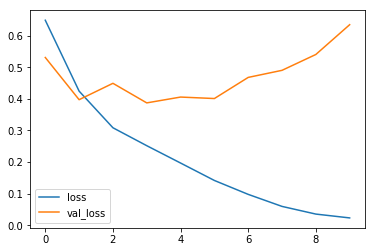

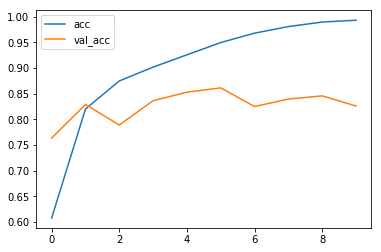

In [16]:
import matplotlib.pyplot as plt
plt.plot(history['loss'], label = 'loss')            
plt.plot(history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history['acc'], label = 'acc')            
plt.plot(history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()


### <font color = 'red'> 연습문제 7-2 : LSTM 으로 IMDB 다루기
위의 예제 노드를 LSTM으로 변경하여 처리하고 그 결과를 비교해보자. 

